## Multimodal Predictive Framework for Autism Diagnosis Using Eye-Tracking Scan Path Image Analysis
### `Vaishnav Krishna P`

### 1. IMPORTS & DRIVE MOUNT

In [38]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, Input, Model, regularizers
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. DEFINE PATHS

In [5]:
# Set paths for images and metadata CSV
img_dir = '/content/drive/MyDrive/Images'
meta_path = '/content/Metadata_Participants.csv'

### 3. LOAD & PREPROCESS METADATA

In [6]:
metadata = pd.read_csv(meta_path)

In [7]:
metadata = metadata[['ParticipantID', 'Gender', 'Age', 'Class', 'CARS Score']]

In [8]:
# convert the categorical to numerical
metadata['Gender'] = metadata['Gender'].map({'M': 1, 'F': 0})
metadata['Class'] = metadata['Class'].map({'TS': 1, 'TC': 0})

In [9]:
# Rename columns
metadata.rename(columns={
    'ParticipantID': 'Participant_ID',
    'Class': 'Group',
    'CARS Score': 'CARS'
}, inplace=True)

In [10]:
# Drop rows with missing CARS scores
metadata = metadata.dropna(subset=['CARS']).copy()

### 4. LOAD IMAGES & MATCH WITH METADATA

In [11]:
image_data, meta_data, labels = [], [], []
img_height, img_width = 128, 128

In [12]:
# Iterate through folders for both classes
for cls_folder in ['TCImages', 'TSImages']:
    folder_path = os.path.join(img_dir, cls_folder)
    label = 0 if cls_folder == 'TCImages' else 1

    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            # Extract participant ID
            parts = filename.split('_')
            pid = int(parts[1].split('.')[0])

            # Find matching metadata row
            row = metadata[metadata['Participant_ID'] == pid]
            if not row.empty:
                # Load and preprocess image
                path = os.path.join(folder_path, filename)
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (img_width, img_height))
                img = img / 255.0

                # Append image and metadata
                image_data.append(img)
                meta = row[['Age', 'Gender', 'CARS']].values[0]
                meta_data.append(meta)
                labels.append(label)

In [13]:
image_data = np.expand_dims(np.array(image_data), -1)
meta_data = np.array(meta_data)
labels = np.array(labels)

### 5. NORMALIZE META DATA

In [14]:
scaler = StandardScaler()
meta_data = scaler.fit_transform(meta_data)

### 6. TRAIN-VALIDATION SPLIT

In [15]:
X_img_train, X_img_val, X_meta_train, X_meta_val, y_train, y_val = train_test_split(
    image_data, meta_data, labels,
    test_size=0.2, stratify=labels, random_state=42
)

### 7. BUILD MULTIMODAL MODEL

In [16]:
# data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

In [17]:
img_input = Input(shape=(img_height, img_width, 1), name="image_input")

In [18]:
# Convert grayscale to RGB for MobileNetV2
x_img = layers.Concatenate()([img_input, img_input, img_input])
x_img = data_augmentation(x_img)

In [19]:
# Pretrained feature extractor
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [20]:
x_img = base_model(x_img, training=False)
x_img = layers.GlobalAveragePooling2D()(x_img)
x_img = layers.Dropout(0.3)(x_img)  # Regularization

In [21]:
meta_input = Input(shape=(3,), name="meta_input")
x_meta = layers.Dense(16, activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4))(meta_input)
x_meta = layers.Dropout(0.5)(x_meta)

In [22]:
# ATTENTION-BASED FUSION
# 1. Project both features to same dimension
proj_img = layers.Dense(32, activation='relu')(x_img)
proj_meta = layers.Dense(32, activation='relu')(x_meta)

# 2. Learn attention weights
alpha_img = layers.Dense(1, activation='sigmoid')(proj_img)
alpha_meta = layers.Dense(1, activation='sigmoid')(proj_meta)

# 3. Apply weighting
weighted_img = layers.Multiply()([proj_img, alpha_img])
weighted_meta = layers.Multiply()([proj_meta, alpha_meta])

# 4. Fuse both modalities
fused = layers.Concatenate()([weighted_img, weighted_meta])
fused = layers.Dense(32, activation='relu')(fused)
fused = layers.Dropout(0.3)(fused)

# 5. Final classification layer
output = layers.Dense(1, activation='sigmoid')(fused)

# 6. Build model
model = Model(inputs=[img_input, meta_input], outputs=output)

### 8. COMPILE & TRAIN

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
# Compute class weights for imbalanced dataset
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(labels), y=labels
)
class_weights = dict(enumerate(class_weights))

In [25]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

In [26]:
# Train model
history = model.fit(
    [X_img_train, X_meta_train], y_train,
    validation_data=([X_img_val, X_meta_val], y_val),
    epochs=10,
    batch_size=16,
    class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 267ms/step - accuracy: 0.4524 - loss: 0.7067 - val_accuracy: 1.0000 - val_loss: 0.6198
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8301 - loss: 0.6046 - val_accuracy: 1.0000 - val_loss: 0.5813
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8214 - loss: 0.5931 - val_accuracy: 1.0000 - val_loss: 0.5345
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9195 - loss: 0.5217 - val_accuracy: 1.0000 - val_loss: 0.4593
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9544 - loss: 0.4389 - val_accuracy: 1.0000 - val_loss: 0.3557
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9956 - loss: 0.3086 - val_accuracy: 1.0000 - val_loss: 0.2541
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9838 - loss: 0.2415 - val_accuracy: 1.0000 - val_loss: 0.1696
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9728 - loss: 0.1828 - val_accuracy: 1.0000 -

### 9 VISUALISATION OF RESULT

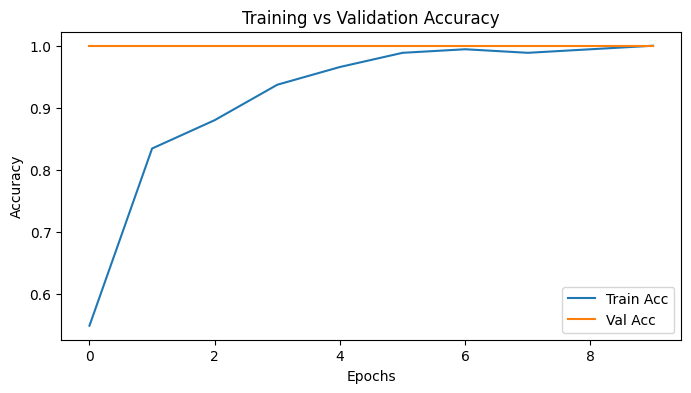

In [27]:
bplt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### 10 SAVE MODEL & SCALER

In [32]:
# save model
model_save_path = "/content/drive/MyDrive/autism_multimodal_model.keras"
model.save(model_save_path)
print(f"Model saved to {model_save_path} (native Keras format)")

# save scaler
scaler_save_path = "/content/drive/MyDrive/meta_scaler.pkl"
with open(scaler_save_path, "wb") as f:
    pickle.dump(scaler, f)
print(f"Scaler saved to {scaler_save_path} (pickle format)")

Model saved to /content/drive/MyDrive/autism_multimodal_model.keras (native Keras format)
Scaler saved to /content/drive/MyDrive/meta_scaler.pkl (pickle format)


### 11 LOAD MODEL

In [35]:
model_save_path = "/content/drive/MyDrive/autism_multimodal_model.keras"
scaler_save_path = "/content/drive/MyDrive/meta_scaler.pkl"

# Load model
model = load_model(model_save_path)
print("Model loaded successfully")

# Load scaler
with open(scaler_save_path, "rb") as f:
    scaler = pickle.load(f)
print("Scaler loaded successfully")

Model loaded successfully
Scaler loaded successfully


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### PREDICTION USING RANDOM IMAGES

In [39]:
uploaded = files.upload()

for fname in uploaded.keys():
    img_path = fname
    # Load image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_height, img_width = 128, 128
    img = cv2.resize(img, (img_width, img_height))
    img = img / 255.0
    img = np.expand_dims(img, axis=(0,-1))

    # meta data
    sample_meta = np.array([[12, 1, 32.5]], dtype=np.float32)
    sample_meta = scaler.transform(sample_meta)

    # prediction
    pred = model.predict([img, sample_meta])
    prob = float(pred[0][0])
    cls = "TS (Autism)" if prob > 0.5 else "TC (Control)"

    print(f"Predicted Probability: {prob:.4f}")
    print(f"Predicted Class: {cls}")

Saving TS002_11.png to TS002_11.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Probability: 0.9143
Predicted Class: TS (Autism)
